/var/folders/p_/rq2plg214fx0yv72l4tsnccr0000gn/T/ipykernel_45496/691888254.py:14: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  tweets["created_at"] = pd.to_datetime(tweets["created_at"], errors="coerce")
/var/folders/p_/rq2plg214fx0yv72l4tsnccr0000gn/T/ipykernel_45496/691888254.py:85: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  combined = combined.fillna(method="ffill")


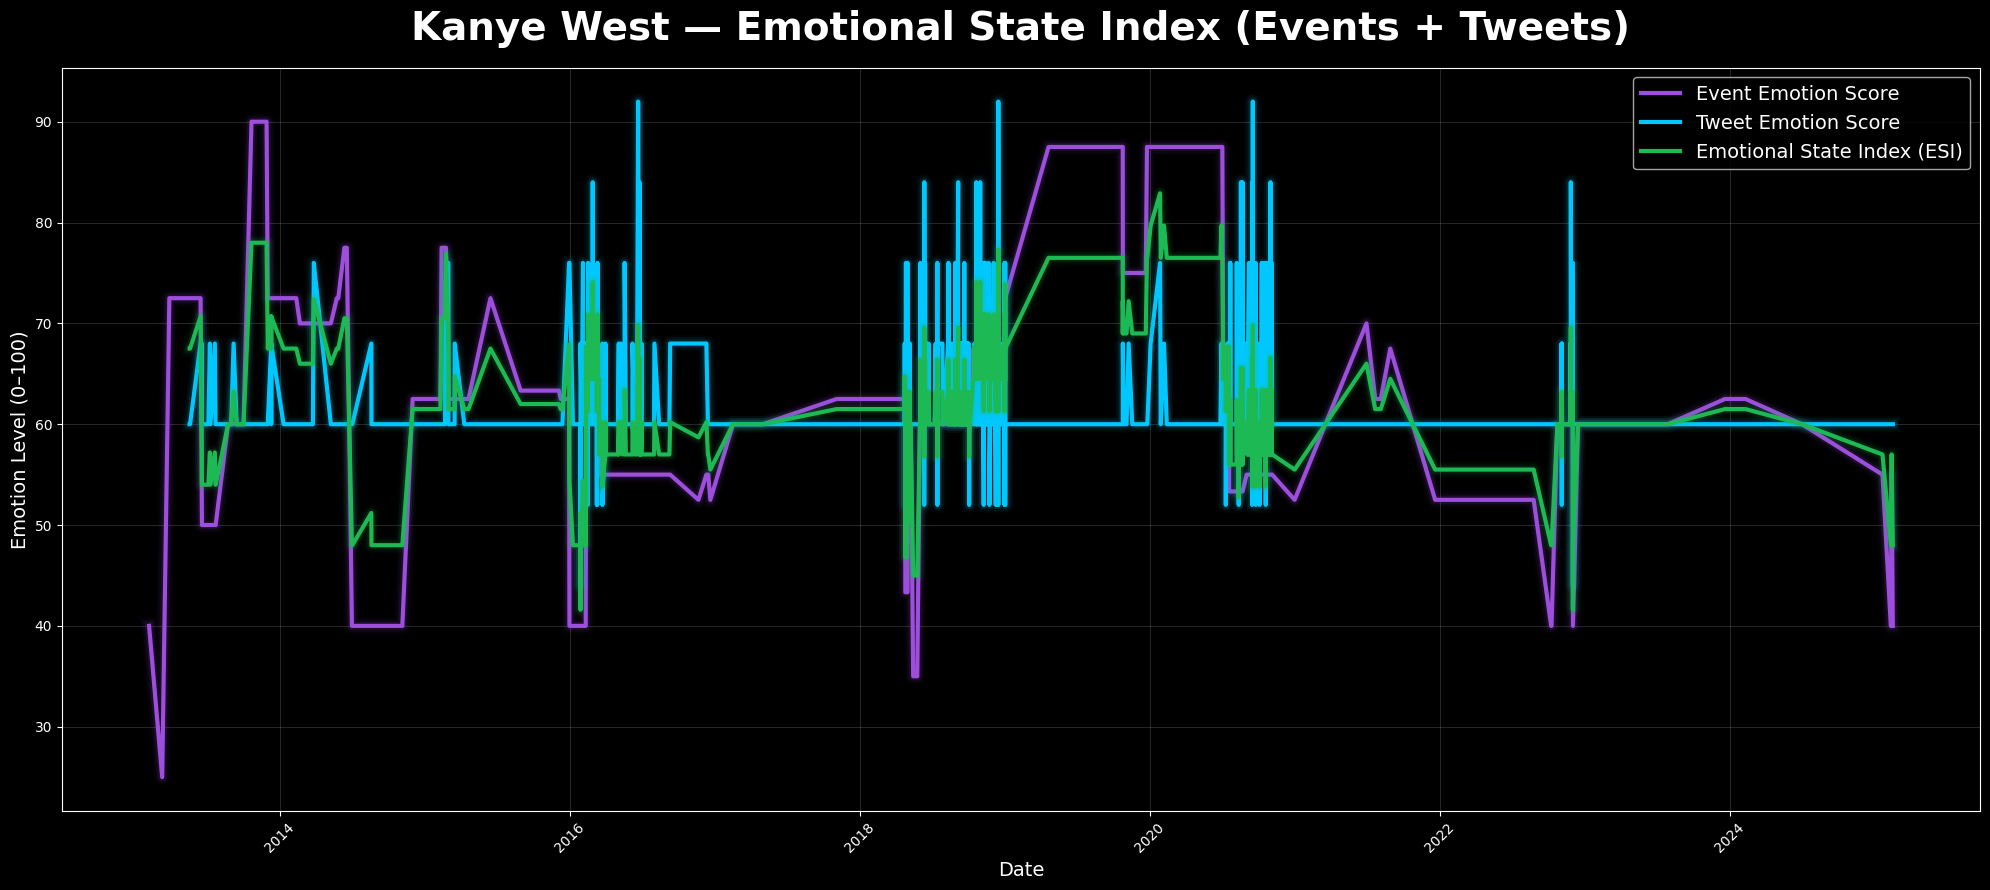

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ============================
# 1. LOAD DATA
# ============================

events = pd.read_csv("events.csv")
tweets = pd.read_csv("tweets_clean.csv")

# Convert dates
events["date"] = pd.to_datetime(events["date"], errors="coerce")
tweets["created_at"] = pd.to_datetime(tweets["created_at"], errors="coerce")

# FIX TIMEZONE ISSUE (remove UTC tz-info)
if tweets["created_at"].dt.tz is not None:
    tweets["created_at"] = tweets["created_at"].dt.tz_localize(None)

# ============================
# 2. EMOTION MAP FOR EVENTS (0–100)
# ============================

emotion_map = {
    "rage": 0, "anger": 20, "frustration": 30, "anxiety": 40,
    "sadness": 45, "confusion": 50, "neutral": 60, "anticipation": 65,
    "ambition": 70, "excitement": 75, "pride": 80, "joy": 85,
    "spirituality": 90, "love": 95
}

def score_event_emotions(text):
    emos = [e.strip() for e in str(text).split(";")]
    scores = [emotion_map.get(e, 60) for e in emos]
    return np.mean(scores)

events["emotion_score_event"] = events["emotion_expected"].apply(score_event_emotions)

# ============================
# 3. SIMPLE TWEET EMOTION ANALYZER
# ============================

positive_words = [
    "love","joy","happy","great","amazing","thank","good","beautiful",
    "family","music","blessed","spiritual","god","hope"
]

negative_words = [
    "hate","angry","sad","fear","bad","upset","pain","stress","anxiety",
    "cry","crazy","lost","broken"
]

def tweet_emotion_score(text):
    text = str(text).lower()
    score = 60  # neutral baseline

    for w in positive_words:
        if w in text:
            score += 8

    for w in negative_words:
        if w in text:
            score -= 8

    return max(0, min(100, score))

tweets["emotion_score_tweet"] = tweets["text"].apply(tweet_emotion_score)

# ============================
# 4. DAILY AGGREGATION
# ============================

event_daily = events.groupby("date")["emotion_score_event"].mean().reset_index()

tweet_daily = tweets.groupby("created_at")["emotion_score_tweet"].mean().reset_index()
tweet_daily = tweet_daily.rename(columns={"created_at": "date"})

# ============================
# 5. MERGE INTO ONE TIMELINE
# ============================

combined = pd.merge(event_daily, tweet_daily, on="date", how="outer")
combined = combined.sort_values("date")

# Fill missing values via forward-fill
combined = combined.fillna(method="ffill")

# ============================
# 6. FINAL EMOTIONAL STATE INDEX (0–100)
# ============================

combined["ESI"] = (
    combined["emotion_score_event"] * 0.6 +
    combined["emotion_score_tweet"] * 0.4
)

# ============================
# 7. BEAUTIFUL VISUALIZATION WITH GLOW EFFECT
# ============================

plt.style.use("dark_background")

def glow_line(ax, x, y, color, label):
    for lw, alpha in [(12, 0.03), (9, 0.06), (6, 0.1)]:
        ax.plot(x, y, color=color, linewidth=lw, alpha=alpha)
    ax.plot(x, y, color=color, linewidth=3, label=label)

fig, ax = plt.subplots(figsize=(20, 9))

# LINE 1 — Events Emotion
glow_line(ax, combined["date"], combined["emotion_score_event"], "#9D4EDD", "Event Emotion Score")

# LINE 2 — Tweet Emotion
glow_line(ax, combined["date"], combined["emotion_score_tweet"], "#00C8FF", "Tweet Emotion Score")

# LINE 3 — Combined ESI
glow_line(ax, combined["date"], combined["ESI"], "#1DB954", "Emotional State Index (ESI)")

# Styling
ax.set_title(
    "Kanye West — Emotional State Index (Events + Tweets)",
    fontsize=28, fontweight="bold", pad=20
)
ax.set_xlabel("Date", fontsize=14)
ax.set_ylabel("Emotion Level (0–100)", fontsize=14)
ax.grid(alpha=0.15)

plt.legend(fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()